 #  A Whale off the Port(folio)
 ---

 In this assignment, you'll get to use what you've learned this week to evaluate the performance among various algorithmic, hedge, and mutual fund portfolios and compare them against the S&P 500 Index.

In [281]:
# Initial imports
import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path
import seaborn as sns

%matplotlib inline

In [282]:
# function to join multiple dataframes, passed as a list, into a single DataFrame and return. 
# The axis and type of join must also be passed as parameters.
def combine_list(lst, axe, join):
    combined = pd.concat(lst, axis=axe, join=join)
    return combined

In [283]:
# Function that takes the pathname to a csv file, reads it into a dataframe and returns
def csv_to_df(pathname):
    filepath = Path(pathname)
    df = pd.read_csv(pathname)
    return df

In [284]:
# This function takes a dataframe and convert the Date column to a datetime format, set it as index, and return
def set_date_index(df):
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    df.set_index(['Date'], inplace=True)
    return df

In [285]:
# Function that takes a dataframe, drops null values, and returns
def drop_null(df):
    df.dropna(inplace=True)
    return df

In [286]:
# Function that takes a dataframe, calculates the percent change between records, drops null values, and returns
def change(df):
    change_df = df.pct_change()
    drop_null(change_df)
    return change_df

In [287]:
# Function that takes a dataframe and a column list, then rename the columns as per the list; and return
def rename_columns(df, column_names):
    df.columns = column_names
    return df

In [288]:
# This function takes the combined returns and the rolling window, then returns the plot of the rolling std 
def rolling_std(returns_df, window):
    # Calculate rolling standard deviation
    rolling_std = returns_df.rolling(window=window).std()
    # Plot rolling standard deviation
    rolling_std_plot = rolling_std.plot(figsize=(20,10),title=f"Rolling {window}-Day Standard Deviation")
    return rolling_std_plot

In [289]:
# This function takes a combined dataframe and returns the correlation matrix
def correlation_matrix(returns_df):
    # Calculate the correlation
    correlation = returns_df.corr()
    return correlation

In [290]:
# This function computes and returns the rolling beta plot
# It takes a combined portfolio, the chosen portfolio, the benchmark portfolio, and the desired rolling window
def get_rolling_beta(combined_portfolio, chosen_column, base_column, rolling_window):
    # Calculate rolling_window-Day rolling covariance of a single portfolio
    rolling_covariance = combined_portfolio[chosen_column].rolling(window=rolling_window).cov(combined_portfolio[base_column])
    # Calculate variance of base-column
    rolling_variance = combined_portfolio[base_column].rolling(window=rolling_window).var()
    # Computing beta
    rolling_beta = rolling_covariance / rolling_variance
    # return Plot of beta trend
    #rolling_beta_plot = rolling_beta.plot(figsize=(20,10), title=f'Rolling {rolling_window}-Day Beta of {chosen_column}')
    return rolling_beta

In [291]:
# This function computes and returns the annualized sharpe ratio of the portfolio passed as parameter
def get_sharpe_ratio(portfolio_returns):
    annualized_std = portfolio_returns.std()*np.sqrt(252)
    sharpe_ratios = portfolio_returns.mean() * 252 / annualized_std
    return sharpe_ratios

# Data Cleaning

In this section, you will need to read the CSV files into DataFrames and perform any necessary data cleaning steps. After cleaning, combine all DataFrames into a single DataFrame.

Files:

* `whale_returns.csv`: Contains returns of some famous "whale" investors' portfolios.

* `algo_returns.csv`: Contains returns from the in-house trading algorithms from Harold's company.

* `sp500_history.csv`: Contains historical closing prices of the S&P 500 Index.

## Whale Returns

Read the Whale Portfolio daily returns and clean the data

In [292]:
# Reading whale returns
#whale_returns_path = Path("Resources/whale_returns.csv")
#whale_returns = pd.read_csv(whale_returns_path, index_col='Date', parse_dates=True, infer_datetime_format=True)

whale_returns = csv_to_df("Resources/whale_returns.csv")  # function to read csv data
whale_returns = set_date_index(whale_returns)  # function to set Date as index
whale_returns.head()

,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC
Date,,,,
2015-03-02,NaN,NaN,NaN,NaN
2015-03-03,-0.001266,-0.004981,-0.000496,-0.006569
2015-03-04,0.002230,0.003241,-0.002534,0.004213
2015-03-05,0.004016,0.004076,0.002355,0.006726
2015-03-06,-0.007905,-0.003574,-0.008481,-0.013098


In [293]:
# Count nulls
whale_returns.isnull().count()

SOROS FUND MANAGEMENT LLC      1060
PAULSON & CO.INC.              1060
TIGER GLOBAL MANAGEMENT LLC    1060
BERKSHIRE HATHAWAY INC         1060
dtype: int64

In [294]:
# Drop nulls
whale_returns.dropna(inplace=True)
whale_returns.isnull().sum()

SOROS FUND MANAGEMENT LLC      0
PAULSON & CO.INC.              0
TIGER GLOBAL MANAGEMENT LLC    0
BERKSHIRE HATHAWAY INC         0
dtype: int64

## Algorithmic Daily Returns

Read the algorithmic daily returns and clean the data

In [295]:
# Reading algorithmic returns
#algo_returns_path = Path("Resources/algo_returns.csv")
#algo_returns = pd.read_csv(algo_returns_path, index_col="Date", parse_dates=True, infer_datetime_format=True)
algo_returns = csv_to_df("Resources/algo_returns.csv")  # function to read csv data
algo_returns = set_date_index(algo_returns)
algo_returns.head()

,Algo 1,Algo 2
Date,,
2014-05-28,0.001745,NaN
2014-05-29,0.003978,NaN
2014-05-30,0.004464,NaN
2014-06-02,0.005692,NaN
2014-06-03,0.005292,NaN


In [296]:
# Count nulls
algo_returns.isnull().value_counts()

Algo 1  Algo 2
False   False     1235
        True         6
dtype: int64

In [297]:
# Drop nulls
algo_returns.dropna(inplace=True)
algo_returns.isnull().value_counts()

Algo 1  Algo 2
False   False     1235
dtype: int64

## S&P 500 Returns

Read the S&P 500 historic closing prices and create a new daily returns DataFrame from the data. 

In [298]:
# Reading S&P 500 Closing Prices
sp500_history = csv_to_df("Resources/sp500_history.csv")  # function to read csv data
sp500_history = set_date_index(sp500_history)
sp500_history.head()

,Close
Date,
2019-04-23,$2933.68
2019-04-22,$2907.97
2019-04-18,$2905.03
2019-04-17,$2900.45
2019-04-16,$2907.06


In [299]:
# Check Data Types
sp500_history.dtypes

Close    object
dtype: object

In [300]:
# Fix Data Types
sp500_history["Close"] = sp500_history["Close"].str.replace("$","")
sp500_history["Close"] = sp500_history["Close"].astype("float")
sp500_history.dtypes

C:\Users\Kuitche\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


Close    float64
dtype: object

In [301]:
# Calculate Daily Returns
sp500_returns = sp500_history.pct_change()
sp500_returns.head()

,Close
Date,
2019-04-23,NaN
2019-04-22,-0.008764
2019-04-18,-0.001011
2019-04-17,-0.001577
2019-04-16,0.002279


In [302]:
# Drop nulls
sp500_returns.dropna(inplace=True)
sp500_returns.head()

,Close
Date,
2019-04-22,-0.008764
2019-04-18,-0.001011
2019-04-17,-0.001577
2019-04-16,0.002279
2019-04-15,-0.000509


In [303]:
# Rename `Close` Column to be specific to this portfolio.
sp500_returns.rename(columns={"Close": "S&P TSX"}, inplace=True)
sp500_returns.head()

,S&P TSX
Date,
2019-04-22,-0.008764
2019-04-18,-0.001011
2019-04-17,-0.001577
2019-04-16,0.002279
2019-04-15,-0.000509


## Combine Whale, Algorithmic, and S&P 500 Returns

In [304]:
# Join Whale Returns, Algorithmic Returns, and the S&P 500 Returns into a single DataFrame with columns for each portfolio's returns.
combined_daily_returns = pd.concat([whale_returns, algo_returns, sp500_returns], axis="columns", join="inner")
combined_daily_returns.sort_index(inplace=True)
combined_daily_returns.head()

,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC,Algo 1,Algo 2,S&P TSX
Date,,,,,,,
2015-03-03,-0.001266,-0.004981,-0.000496,-0.006569,-0.001942,-0.000949,0.004408
2015-03-04,0.002230,0.003241,-0.002534,0.004213,-0.008589,0.002416,-0.001195
2015-03-05,0.004016,0.004076,0.002355,0.006726,-0.000955,0.004323,0.014378
2015-03-06,-0.007905,-0.003574,-0.008481,-0.013098,-0.004957,-0.011460,-0.003929
2015-03-09,0.000582,0.004225,0.005843,-0.001652,-0.005447,0.001303,0.017254


---

# Conduct Quantitative Analysis

In this section, you will calculate and visualize performance and risk metrics for the portfolios.

## Performance Anlysis

#### Calculate and Plot the daily returns.

<AxesSubplot:xlabel='Date'>

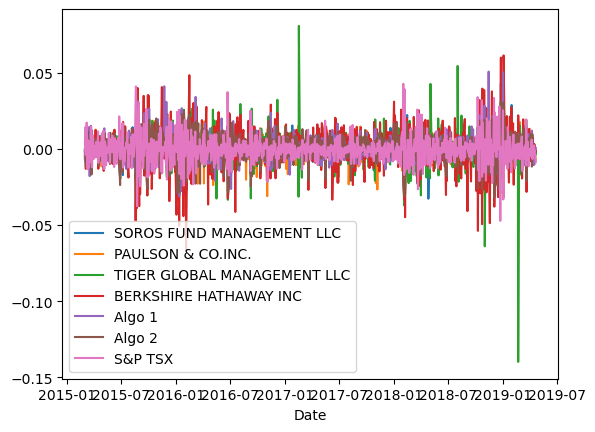

In [305]:
# Plot daily returns of all portfolios
combined_daily_returns.plot()

#### Calculate and Plot cumulative returns.

<AxesSubplot:xlabel='Date'>

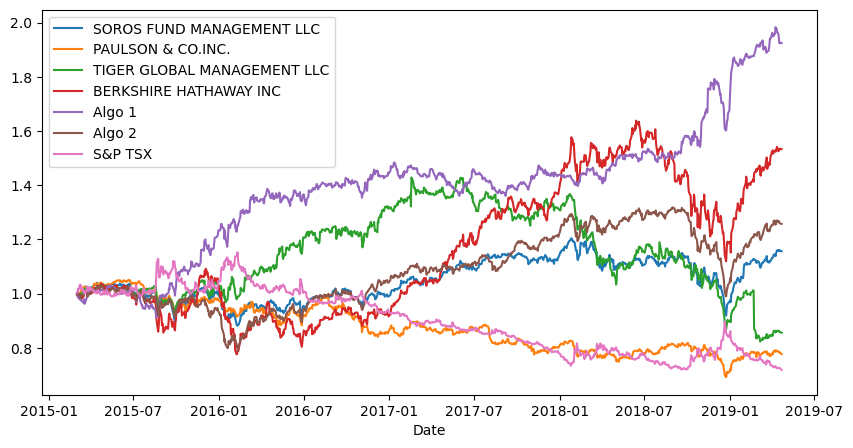

In [306]:
# Calculate cumulative returns of all portfolios
cumulative_combined_returns = (1 + combined_daily_returns).cumprod()
# Plot cumulative returns
cumulative_combined_returns.plot(figsize=(10,5))

---

## Risk Analysis

Determine the _risk_ of each portfolio:

1. Create a box plot for each portfolio. 
2. Calculate the standard deviation for all portfolios
4. Determine which portfolios are riskier than the S&P 500
5. Calculate the Annualized Standard Deviation

### Create a box plot for each portfolio


<AxesSubplot:>

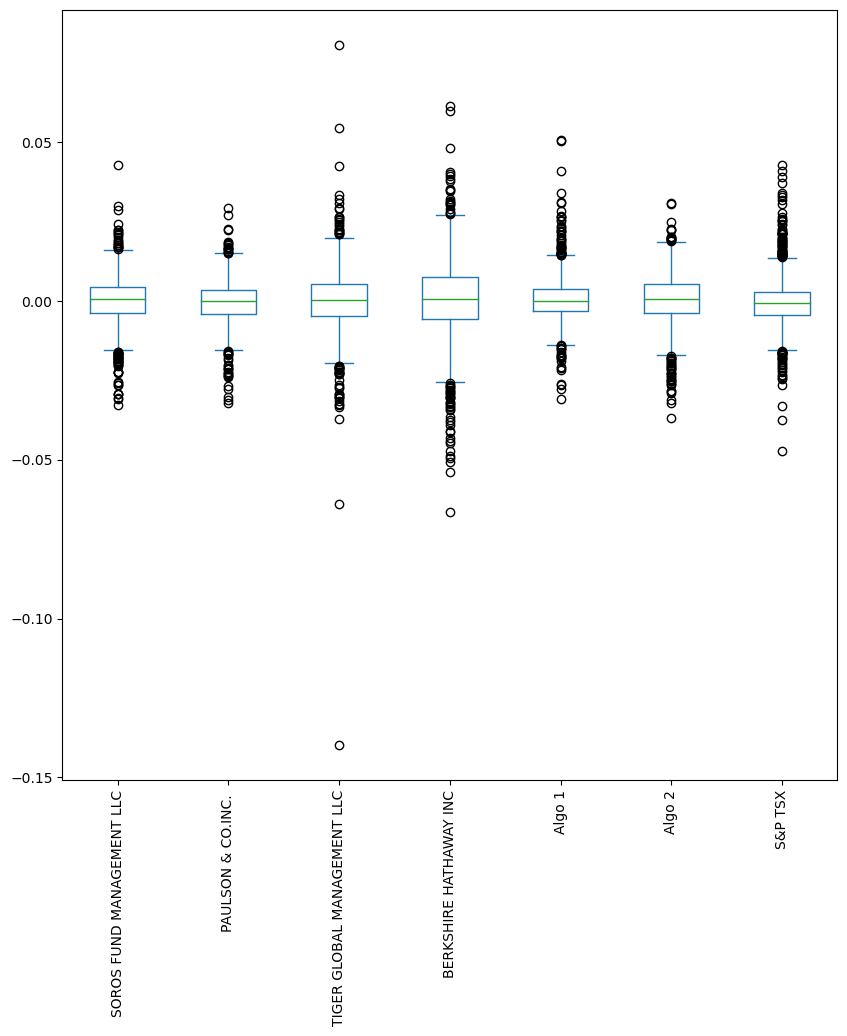

In [307]:
# Box plot to visually show risk
combined_daily_returns.plot.box(rot='vertical', figsize=(10,10))

### Calculate Standard Deviations

In [308]:
# Calculate the daily standard deviations of all portfolios
all_portfolio_std = combined_daily_returns.std()
all_portfolio_std

SOROS FUND MANAGEMENT LLC      0.007896
PAULSON & CO.INC.              0.007026
TIGER GLOBAL MANAGEMENT LLC    0.010897
BERKSHIRE HATHAWAY INC         0.012919
Algo 1                         0.007623
Algo 2                         0.008341
S&P TSX                        0.008587
dtype: float64

### Determine which portfolios are riskier than the S&P 500

Text(0, 0.00867275864454473, 'S&P 500')

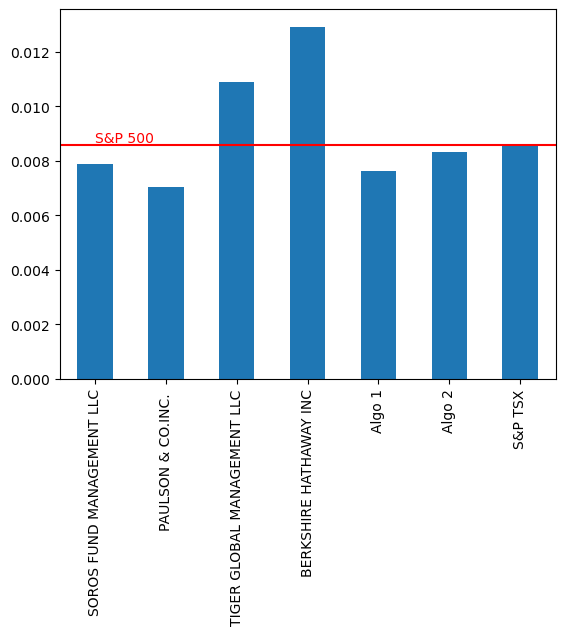

In [309]:
# Calculate  the daily standard deviation of S&P 500
sp500_returns_std = all_portfolio_std['S&P TSX']
# Determine which portfolios are riskier than the S&P 500
bar_plot = all_portfolio_std.plot.bar()
bar_plot.axhline(y=sp500_returns_std, color='red')
bar_plot.text(x=0, y=sp500_returns_std*1.01, s="S&P 500", color='red')

***The portfolios with greater spread (standard deviations) than the S&P 500 are riskier; which are:***
* *BERKSHIRE HATHAWAY INC*
* *TIGER GLOBAL MANAGEMENT LLC*

### Calculate the Annualized Standard Deviation

In [310]:
# Calculate the annualized standard deviation (252 trading days)
annualized_std = all_portfolio_std*np.sqrt(252)
annualized_std

SOROS FUND MANAGEMENT LLC      0.125348
PAULSON & CO.INC.              0.111527
TIGER GLOBAL MANAGEMENT LLC    0.172989
BERKSHIRE HATHAWAY INC         0.205079
Algo 1                         0.121006
Algo 2                         0.132413
S&P TSX                        0.136313
dtype: float64

---

## Rolling Statistics

Risk changes over time. Analyze the rolling statistics for Risk and Beta. 

1. Calculate and plot the rolling standard deviation for all portfolios using a 21-day window
2. Calculate the correlation between each stock to determine which portfolios may mimick the S&P 500
3. Choose one portfolio, then calculate and plot the 60-day rolling beta between it and the S&P 500

### Calculate and plot rolling `std` for all portfolios with 21-day window

<AxesSubplot:title={'center':'Rolling 21-Day Standard Deviation'}, xlabel='Date'>

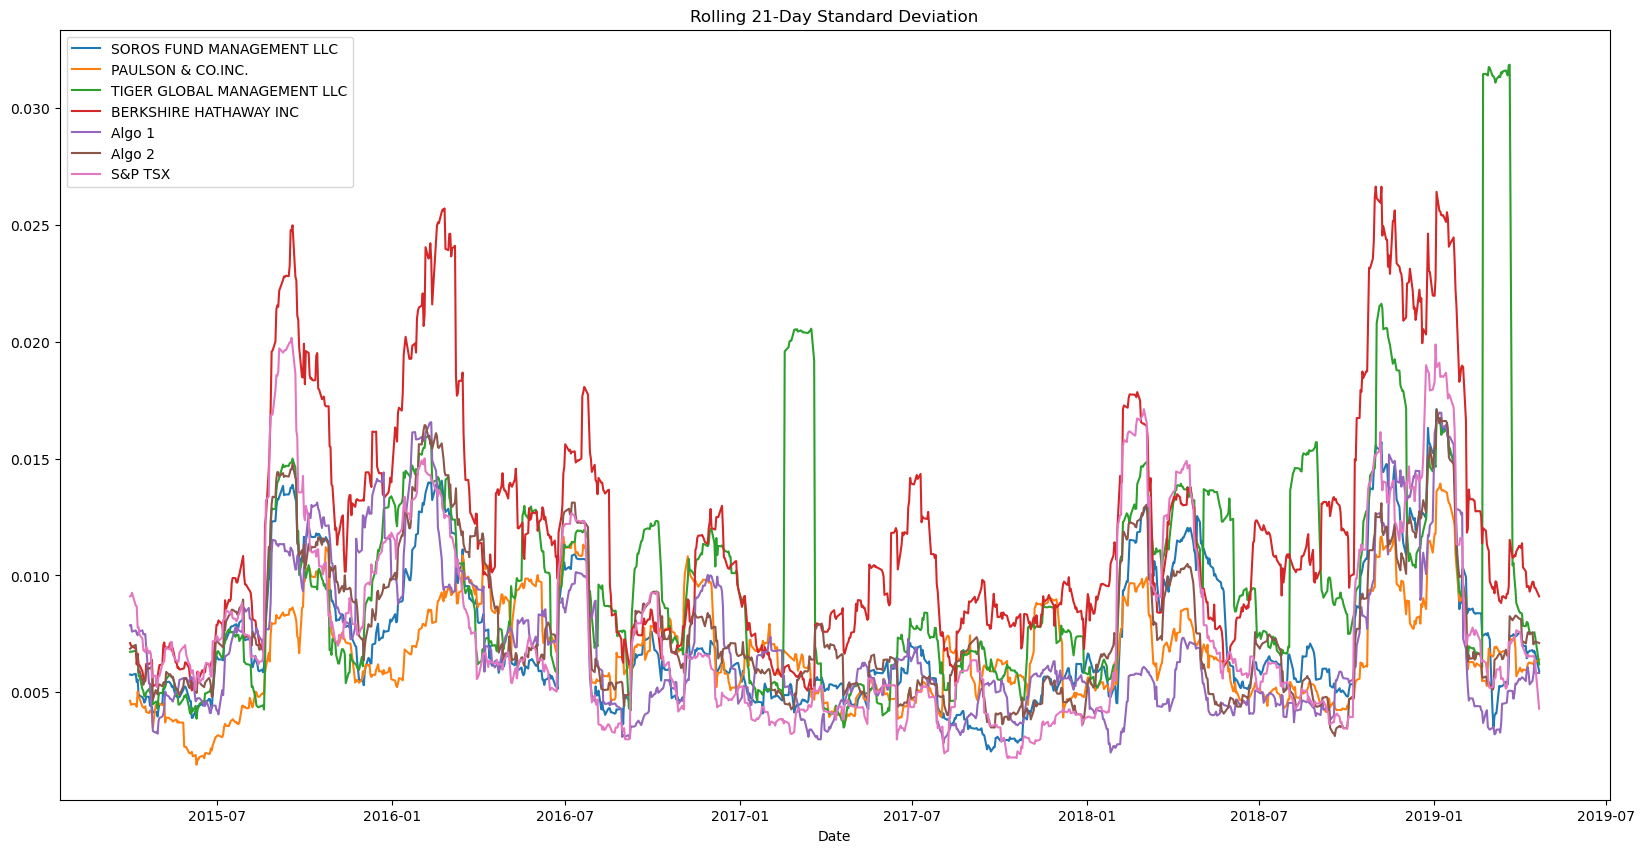

In [311]:
# Calculate the rolling standard deviation for all portfolios using a 21-day window
    # See function call below
# Plot the rolling standard deviation
rolling_std(combined_daily_returns,21)

### Calculate and plot the correlation

In [312]:
# Calculate the correlation
    # see function call
# Display de correlation matrix
correlation_matrix(combined_daily_returns)

,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC,Algo 1,Algo 2,S&P TSX
SOROS FUND MANAGEMENT LLC,1.000000,0.699823,0.561040,0.754157,0.320901,0.826730,0.000574
PAULSON & CO.INC.,0.699823,1.000000,0.434308,0.545451,0.268631,0.678085,0.013549
TIGER GLOBAL MANAGEMENT LLC,0.561040,0.434308,1.000000,0.424125,0.164114,0.507160,-0.001505
BERKSHIRE HATHAWAY INC,0.754157,0.545451,0.424125,1.000000,0.291678,0.687756,-0.013856
Algo 1,0.320901,0.268631,0.164114,0.291678,1.000000,0.287852,-0.033963
Algo 2,0.826730,0.678085,0.507160,0.687756,0.287852,1.000000,-0.002192
S&P TSX,0.000574,0.013549,-0.001505,-0.013856,-0.033963,-0.002192,1.000000


### Calculate and Plot Beta for a chosen portfolio and the S&P 500

<AxesSubplot:title={'center':'Rolling 60-Day Beta of TIGER GLOBAL MANAGEMENT LLC'}, xlabel='Date'>

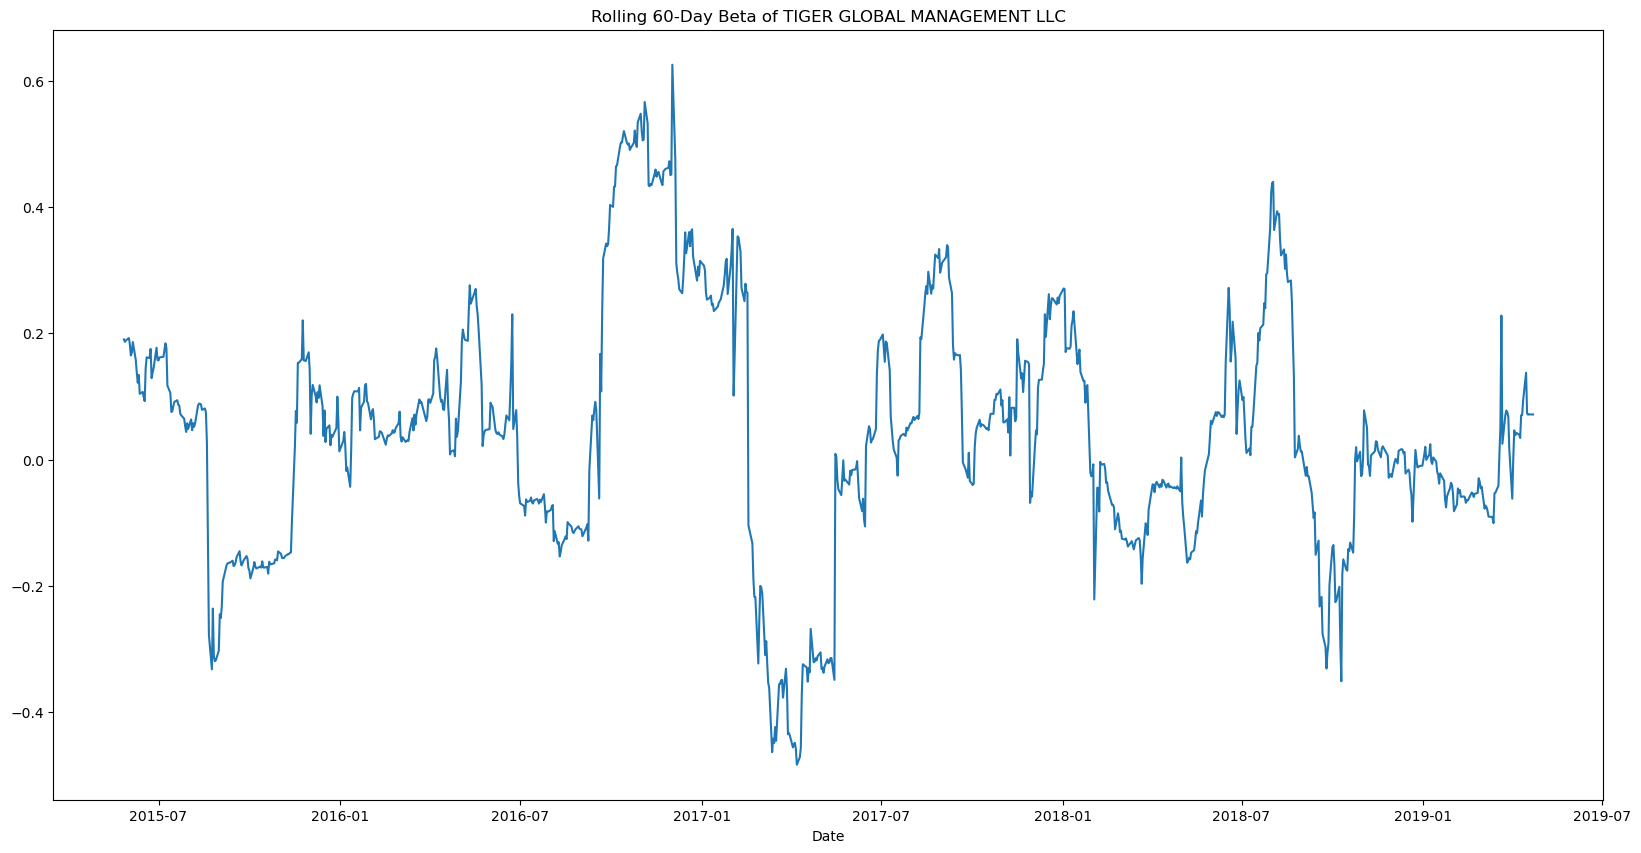

In [313]:
# Calculate 60-day rolling covariance of a single portfolio
#rolling_covariance_TIGER = combined_daily_returns['TIGER GLOBAL MANAGEMENT LLC'].rolling(window=60).cov(combined_daily_returns['S&P TSX'])

# Calculate variance of S&P 500
#rolling_variance_sp500 = combined_daily_returns['S&P TSX'].rolling(window=60).var()

# Computing beta
#rolling_TIGER_beta = rolling_covariance_TIGER / rolling_variance_sp500

# Plot beta trend
#rolling_TIGER_beta.plot(figsize=(20,10), title='Rolling 60-Day Beta of TIGER GLOBAL MANAGEMENT LLC')

rolling_beta = get_rolling_beta(combined_daily_returns, 'TIGER GLOBAL MANAGEMENT LLC', 'S&P TSX', 60)
rolling_beta.plot(figsize=(20,10), title='Rolling 60-Day Beta of TIGER GLOBAL MANAGEMENT LLC')

## Rolling Statistics Challenge: Exponentially Weighted Average 

An alternative way to calculate a rolling window is to take the exponentially weighted moving average. This is like a moving window average, but it assigns greater importance to more recent observations. Try calculating the [`ewm`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html) with a 21-day half life for each portfolio, using standard deviation (`std`) as the metric of interest.

<AxesSubplot:title={'center':'Exponentially Weighted Average 21-Day Standard Deviation'}, xlabel='Date'>

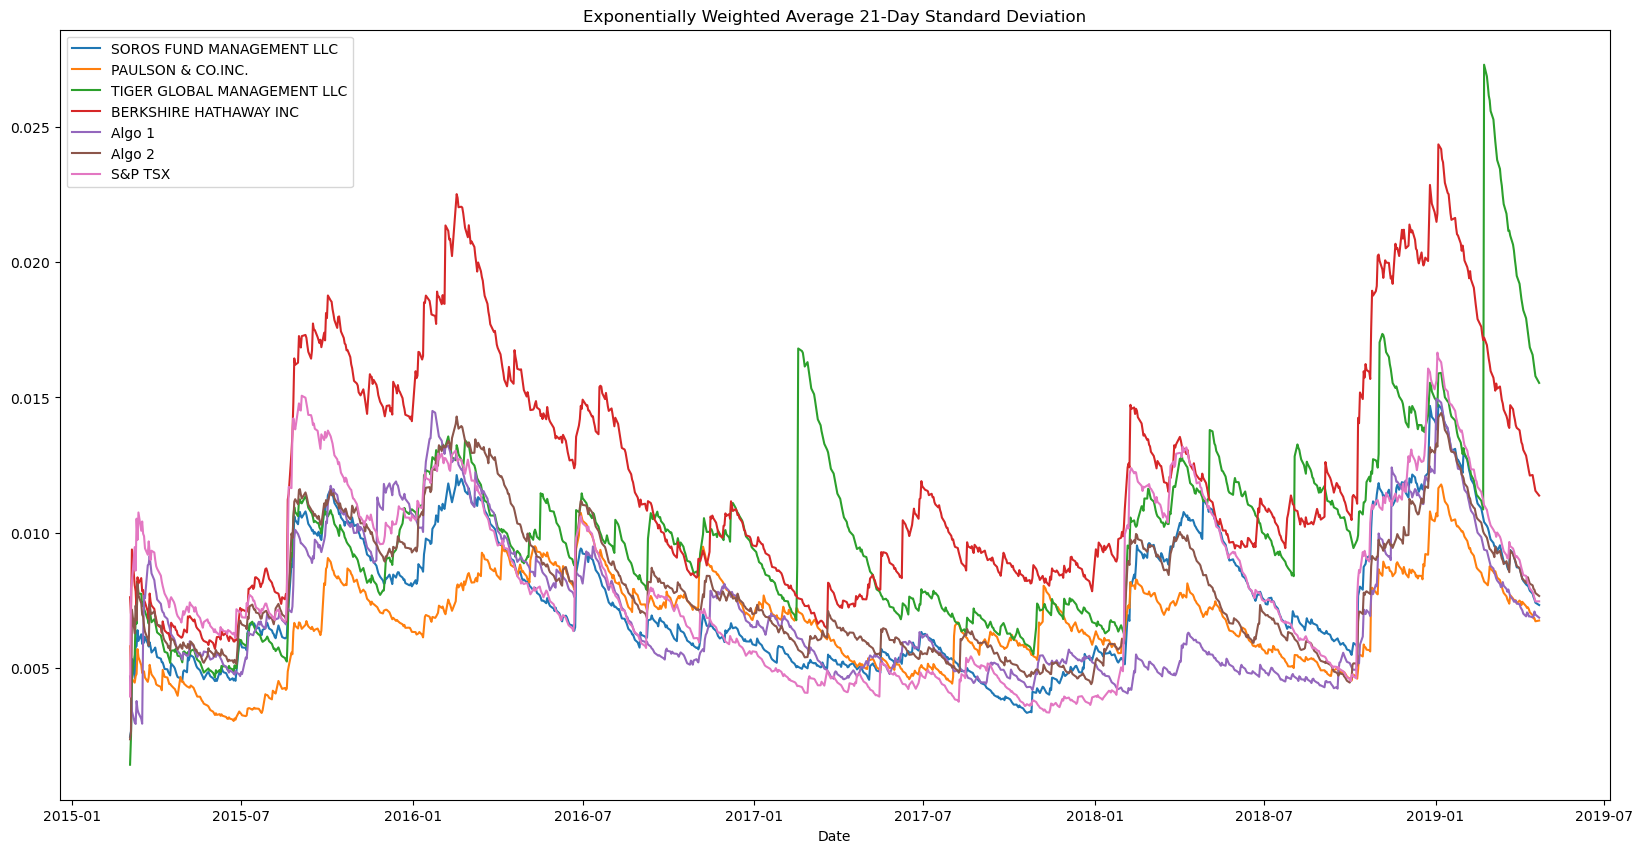

In [314]:
# Use `ewm` to calculate the rolling window
ewm21_std = combined_daily_returns.ewm(halflife=21).std()
ewm21_std.plot(figsize=(20,10),title="Exponentially Weighted Average 21-Day Standard Deviation")

---

# Sharpe Ratios
In reality, investment managers and thier institutional investors look at the ratio of return-to-risk, and not just returns alone. After all, if you could invest in one of two portfolios, and each offered the same 10% return, yet one offered lower risk, you'd take that one, right?

### Using the daily returns, calculate and visualize the Sharpe ratios using a bar plot

In [315]:
# Annualized Sharpe Ratios
sharpe_ratios = combined_daily_returns.mean()*252 / annualized_std
sharpe_ratios

SOROS FUND MANAGEMENT LLC      0.342894
PAULSON & CO.INC.             -0.491422
TIGER GLOBAL MANAGEMENT LLC   -0.130186
BERKSHIRE HATHAWAY INC         0.606743
Algo 1                         1.369589
Algo 2                         0.484334
S&P TSX                       -0.518582
dtype: float64

<AxesSubplot:title={'center':'Sharpe Ratios'}>

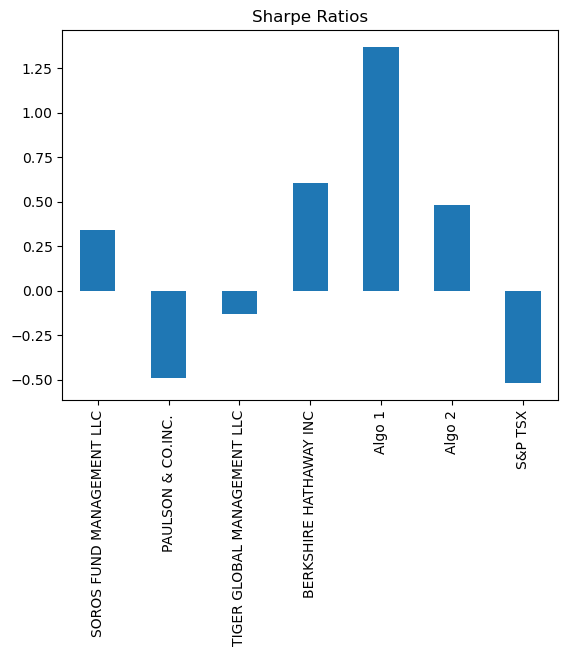

In [316]:
# Visualize the sharpe ratios as a bar plot
sharpe_ratios.plot.bar(title='Sharpe Ratios')

### Determine whether the algorithmic strategies outperform both the market (S&P 500) and the whales portfolios.

Write your answer here!
Yes, the algorithmic strategies outperform both the market and the whales (see below)

In [317]:
# standard deviation for individual portfolio
whale_returns_std_annual = whale_returns.std()*np.sqrt(252)
algo_returns_std_annual = algo_returns.std()*np.sqrt(252)
sp500_returns_std_annual = sp500_returns.std()*np.sqrt(252)

# Sharp Ratio for individual portfolio
whale_sharpe_ratios = whale_returns.mean() * 252 / whale_returns_std_annual
algo_sharpe_ratios = algo_returns.mean() * 252 / algo_returns_std_annual
sp500_sharpe_ratio = sp500_returns.mean() * 252 / sp500_returns_std_annual

# Average Sharpe Ratio for individual portfolio
whale_sharpe_average = whale_sharpe_ratios.mean()
algo_sharpe_average = algo_sharpe_ratios.mean()
sp500_sharpe_average = sp500_sharpe_ratio.mean()

if algo_sharpe_average > sp500_sharpe_average and algo_sharpe_average > whale_sharpe_average:
    print("The algorithmic strategies outperform both the market and the whales")
elif algo_sharpe_average > sp500_sharpe_average:
    print("The algorithmic strategies outperform the market")
elif algo_sharpe_average > whale_sharpe_average:
    print("The algorithmic strategies outperform the whales")

The algorithmic strategies outperform both the market and the whales


---

# Create Custom Portfolio

In this section, you will build your own portfolio of stocks, calculate the returns, and compare the results to the Whale Portfolios and the S&P 500. 

1. Choose 3-5 custom stocks with at last 1 year's worth of historic prices and create a DataFrame of the closing prices and dates for each stock.
2. Calculate the weighted returns for the portfolio assuming an equal number of shares for each stock
3. Join your portfolio returns to the DataFrame that contains all of the portfolio returns
4. Re-run the performance and risk analysis with your portfolio to see how it compares to the others
5. Include correlation analysis to determine which stocks (if any) are correlated

## Choose 3-5 custom stocks with at last 1 year's worth of historic prices and create a DataFrame of the closing prices and dates for each stock.

In [318]:
# Reading data from 1st, 2nd, and 3rd stock through function call and loop
names = ["tgen_prices", "zen_prices", "pypl_prices"]
my_portfolio=[]
for key in names:
    key = csv_to_df("Resources/"+key+".csv")  # function to read csv data
    key = set_date_index(key)   # function to set Date as index
    my_portfolio.append(key)

tgen_prices = my_portfolio[0]
zen_prices = my_portfolio[1]
pypl_prices = my_portfolio[2]
tgen_prices.head()

,Close
Date,
2014-05-28,11.84
2014-05-29,9.49
2014-05-30,8.30
2014-06-02,8.03
2014-06-03,7.47


In [319]:
# Combine all stocks in a single DataFrame
# all_stocks = pd.concat([tgen_prices, zen_prices, pypl_prices], axis='columns', join='inner')
lst = [tgen_prices, zen_prices, pypl_prices]
all_stocks = combine_list(my_portfolio, 'columns', 'inner')
all_stocks

,Close,Close,Close
Date,,,
2015-07-06,4.02,1.41,36.71
2015-07-07,4.21,1.37,36.62
2015-07-08,4.02,1.36,34.70
2015-07-09,4.02,1.33,34.50
2015-07-10,4.23,1.36,34.69
...,...,...,...
2019-04-24,3.97,0.39,107.22
2019-04-25,3.78,0.39,110.22
2019-04-26,3.84,0.39,110.56


In [320]:
# Reorganize portfolio data by having a column per symbol
column_names = ["TGEN", "ZEN", "PYPL"]
rename_columns(all_stocks, column_names)
all_stocks

,TGEN,ZEN,PYPL
Date,,,
2015-07-06,4.02,1.41,36.71
2015-07-07,4.21,1.37,36.62
2015-07-08,4.02,1.36,34.70
2015-07-09,4.02,1.33,34.50
2015-07-10,4.23,1.36,34.69
...,...,...,...
2019-04-24,3.97,0.39,107.22
2019-04-25,3.78,0.39,110.22
2019-04-26,3.84,0.39,110.56


In [321]:
# Calculate daily returns
all_stocks_returns = all_stocks.pct_change()

# Drop NAs
all_stocks_returns.dropna(inplace=True)

# Display sample data
all_stocks_returns.sample()

,TGEN,ZEN,PYPL
Date,,,
2016-07-05,-0.019608,0.014085,-0.010682


## Calculate the weighted returns for the portfolio assuming an equal number of shares for each stock

In [322]:
# Set weights
weights = [1/3, 1/3, 1/3]
# Calculate portfolio return
my_portfolio_returns = all_stocks_returns.dot(weights)
# Display sample data
my_portfolio_returns.sample()

Date
2018-03-23   -0.011294
dtype: float64

## Join your portfolio returns to the DataFrame that contains all of the portfolio returns

In [323]:
# Join your returns DataFrame to the original returns DataFrame
lst = [all_stocks_returns,combined_daily_returns]
combined_returns = combine_list(lst, 'columns', 'inner')
combined_returns

,TGEN,ZEN,PYPL,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC,Algo 1,Algo 2,S&P TSX
Date,,,,,,,,,,
2015-07-07,0.047264,-0.028369,-0.002452,0.000597,0.003962,0.004652,-0.007634,-0.004611,-0.002519,0.016935
2015-07-08,-0.045131,-0.007299,-0.052430,-0.017211,-0.007654,-0.014788,-0.011737,-0.013853,-0.015528,-0.002257
2015-07-09,0.000000,-0.022059,-0.005764,0.007472,0.003887,0.000441,0.017670,0.014090,0.003624,-0.012188
2015-07-10,0.052239,0.022556,0.005507,0.008969,0.003589,0.013605,0.007015,0.003362,0.014381,-0.010945
2015-07-13,0.000000,-0.044118,0.060248,0.007946,0.001149,0.008658,0.010178,0.004215,0.008575,-0.004438
...,...,...,...,...,...,...,...,...,...,...
2019-04-15,-0.017677,0.029412,-0.003134,-0.001422,-0.001156,0.000398,-0.010492,-0.004331,-0.004572,-0.000509
2019-04-16,0.000000,0.057143,0.000555,0.002699,0.000388,-0.000831,0.000837,-0.006945,0.002899,0.002279
2019-04-17,-0.007712,0.027027,0.005638,-0.002897,-0.006467,-0.004409,0.003222,-0.010301,-0.005228,-0.001577


In [324]:
# Only compare dates where return data exists for all the stocks (drop NaNs)
combined_returns.dropna(inplace=True)
combined_returns

,TGEN,ZEN,PYPL,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC,Algo 1,Algo 2,S&P TSX
Date,,,,,,,,,,
2015-07-07,0.047264,-0.028369,-0.002452,0.000597,0.003962,0.004652,-0.007634,-0.004611,-0.002519,0.016935
2015-07-08,-0.045131,-0.007299,-0.052430,-0.017211,-0.007654,-0.014788,-0.011737,-0.013853,-0.015528,-0.002257
2015-07-09,0.000000,-0.022059,-0.005764,0.007472,0.003887,0.000441,0.017670,0.014090,0.003624,-0.012188
2015-07-10,0.052239,0.022556,0.005507,0.008969,0.003589,0.013605,0.007015,0.003362,0.014381,-0.010945
2015-07-13,0.000000,-0.044118,0.060248,0.007946,0.001149,0.008658,0.010178,0.004215,0.008575,-0.004438
...,...,...,...,...,...,...,...,...,...,...
2019-04-15,-0.017677,0.029412,-0.003134,-0.001422,-0.001156,0.000398,-0.010492,-0.004331,-0.004572,-0.000509
2019-04-16,0.000000,0.057143,0.000555,0.002699,0.000388,-0.000831,0.000837,-0.006945,0.002899,0.002279
2019-04-17,-0.007712,0.027027,0.005638,-0.002897,-0.006467,-0.004409,0.003222,-0.010301,-0.005228,-0.001577


## Re-run the risk analysis with your portfolio to see how it compares to the others

### Calculate the Annualized Standard Deviation

In [325]:
# Calculate the annualized `std`
annualized_std = combined_returns.std()*np.sqrt(252)
annualized_std

TGEN                           0.629883
ZEN                            0.754563
PYPL                           0.297694
SOROS FUND MANAGEMENT LLC      0.127683
PAULSON & CO.INC.              0.114510
TIGER GLOBAL MANAGEMENT LLC    0.179697
BERKSHIRE HATHAWAY INC         0.208980
Algo 1                         0.123743
Algo 2                         0.135593
S&P TSX                        0.139070
dtype: float64

### Calculate and plot rolling `std` with 21-day window

<AxesSubplot:title={'center':'Rolling 21-Day Standard Deviation'}, xlabel='Date'>

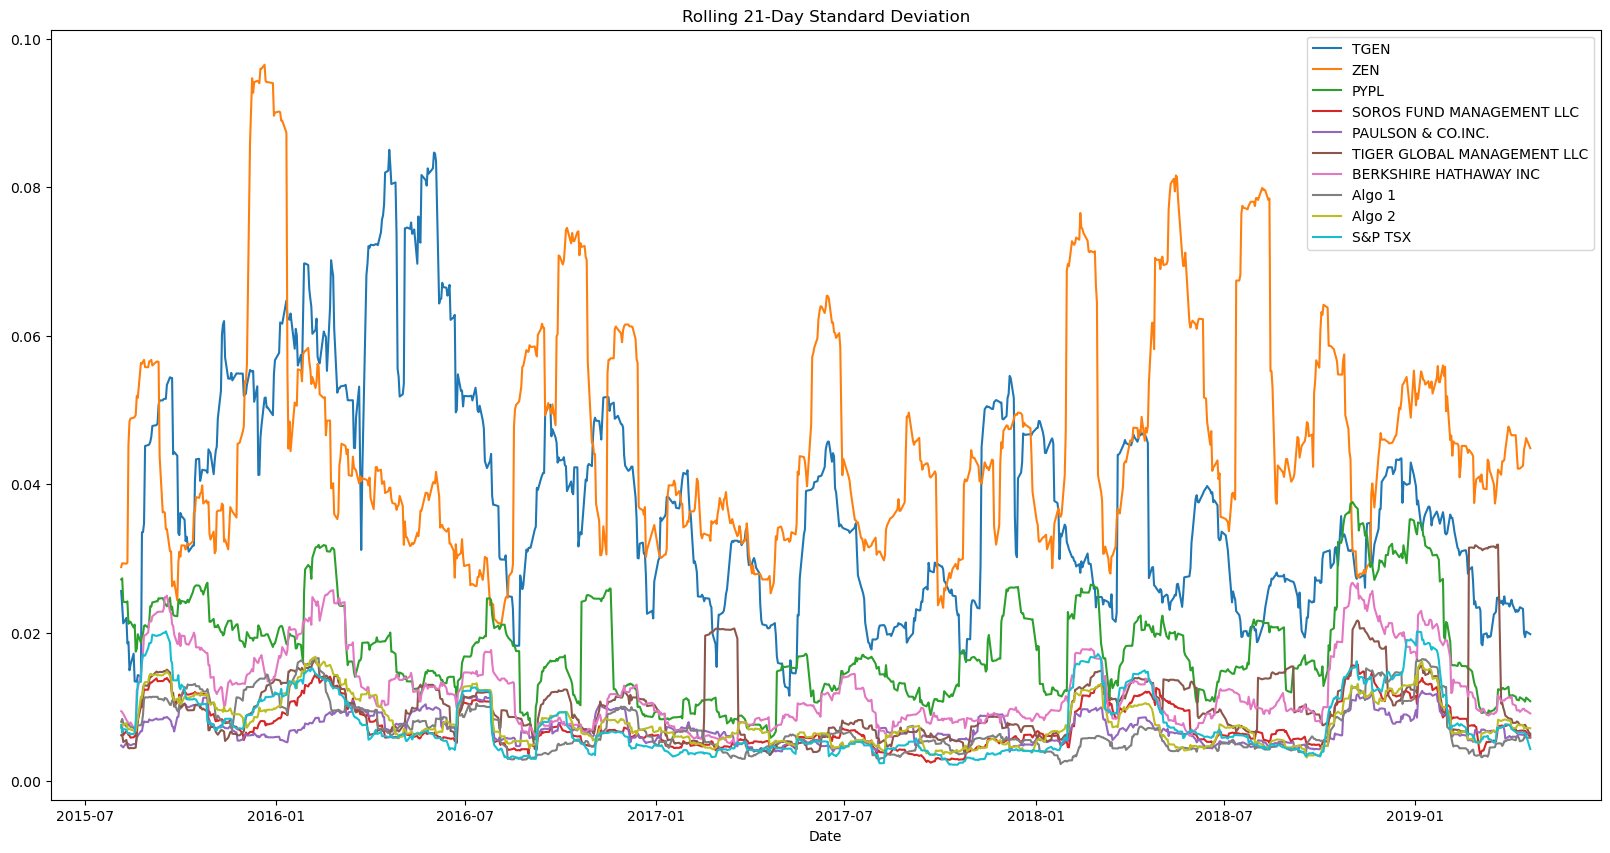

In [326]:
# Calculate rolling standard deviation
    # see function call
# Plot rolling standard deviation
rolling_std(combined_returns,21)

### Calculate and plot the correlation

In [327]:
# Calculate and plot the correlation
correlation_matrix(combined_returns)

,TGEN,ZEN,PYPL,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC,Algo 1,Algo 2,S&P TSX
TGEN,1.000000,0.012417,-0.033946,0.019275,0.030716,0.002877,-0.004113,0.012580,0.040305,0.066473
ZEN,0.012417,1.000000,-0.006400,0.062556,0.036740,0.088360,0.037227,-0.012075,0.028501,0.040443
PYPL,-0.033946,-0.006400,1.000000,0.519599,0.374569,0.356677,0.556906,0.180143,0.489312,-0.038303
SOROS FUND MANAGEMENT LLC,0.019275,0.062556,0.519599,1.000000,0.698356,0.552487,0.750516,0.321124,0.828141,0.004863
PAULSON & CO.INC.,0.030716,0.036740,0.374569,0.698356,1.000000,0.424379,0.542956,0.277177,0.675531,0.011050
TIGER GLOBAL MANAGEMENT LLC,0.002877,0.088360,0.356677,0.552487,0.424379,1.000000,0.417719,0.160793,0.493872,-0.010959
BERKSHIRE HATHAWAY INC,-0.004113,0.037227,0.556906,0.750516,0.542956,0.417719,1.000000,0.300570,0.689228,-0.011510
Algo 1,0.012580,-0.012075,0.180143,0.321124,0.277177,0.160793,0.300570,1.000000,0.294610,-0.036201
Algo 2,0.040305,0.028501,0.489312,0.828141,0.675531,0.493872,0.689228,0.294610,1.000000,-0.014545
S&P TSX,0.066473,0.040443,-0.038303,0.004863,0.011050,-0.010959,-0.011510,-0.036201,-0.014545,1.000000


<AxesSubplot:>

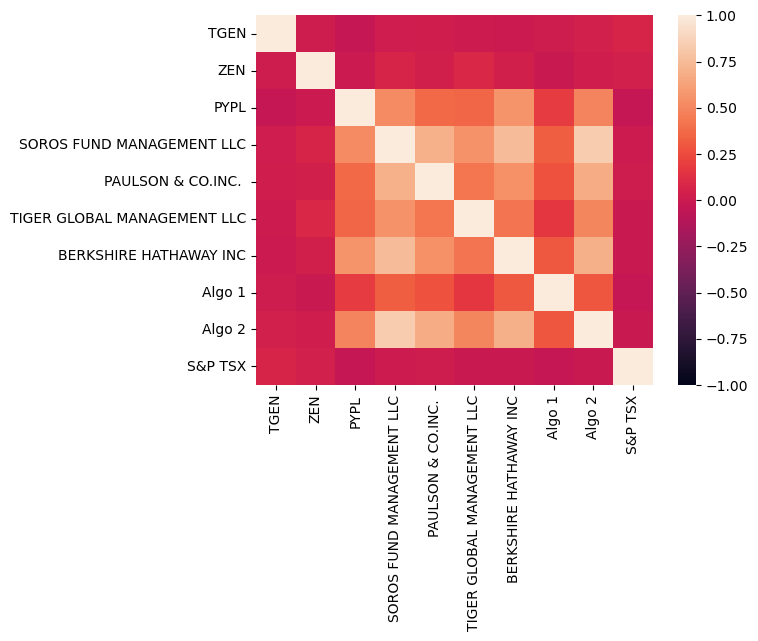

In [328]:
sns.heatmap(correlation_matrix(combined_returns), vmin=-1, vmax=1)

### Calculate and Plot Rolling 60-day Beta for Your Portfolio compared to the S&P 500

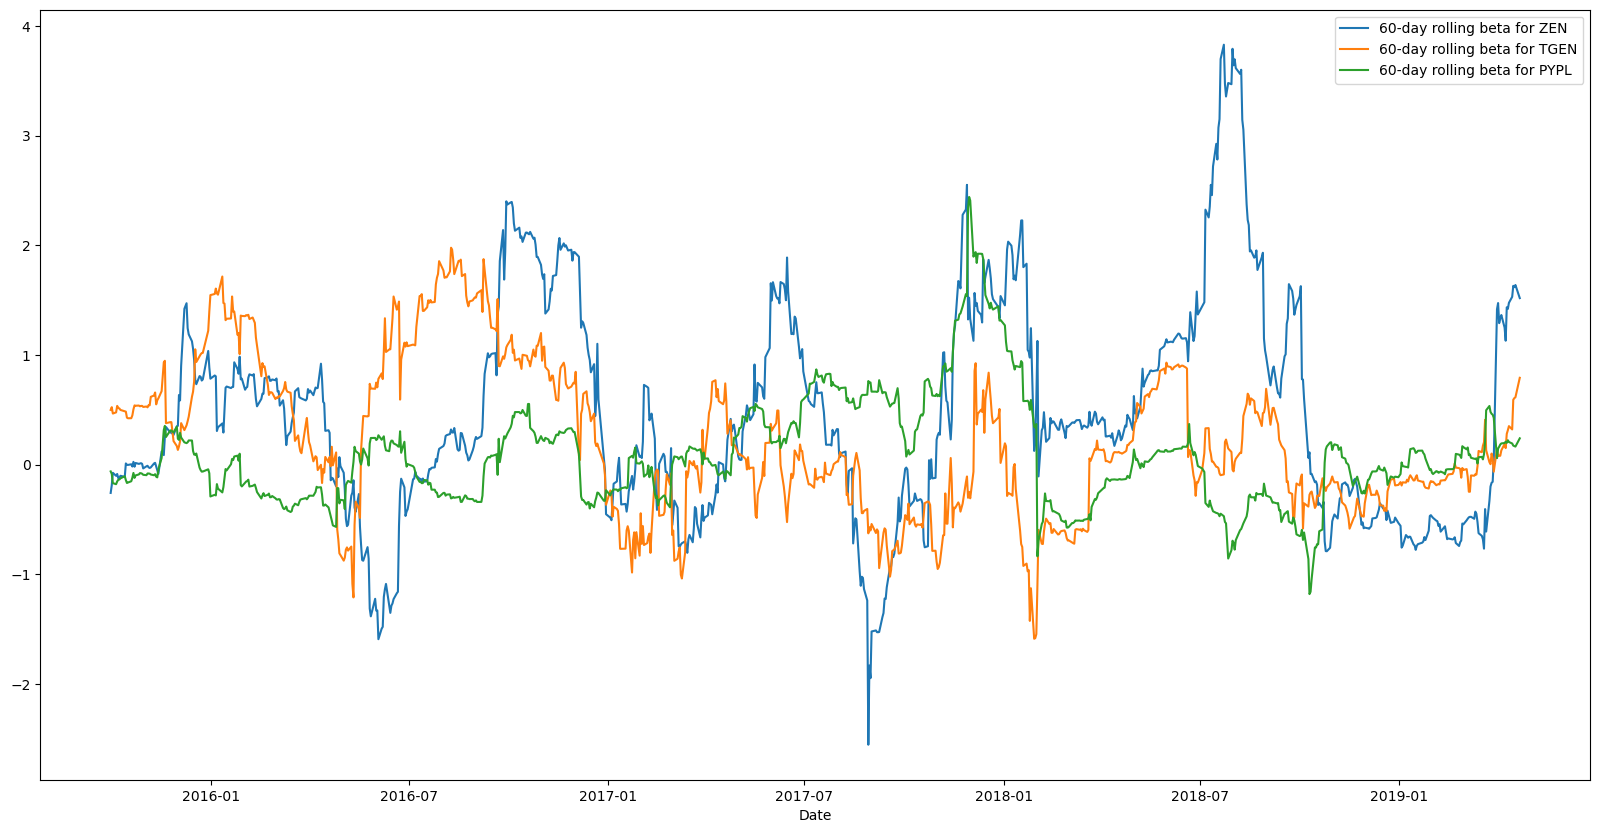

In [329]:
# Calculate and plot Beta
beta_ZEN = get_rolling_beta(combined_returns, 'ZEN', 'S&P TSX', 60)
beta_TGEN = get_rolling_beta(combined_returns, 'TGEN', 'S&P TSX', 60)
beta_PYPL = get_rolling_beta(combined_returns, 'PYPL', 'S&P TSX', 60)
ax = beta_ZEN.plot(figsize=(20,10))
beta_TGEN.plot(ax=ax)
beta_PYPL.plot(ax=ax)
ax.legend(['60-day rolling beta for ZEN', '60-day rolling beta for TGEN', '60-day rolling beta for PYPL'])

### Using the daily returns, calculate and visualize the Sharpe ratios using a bar plot

In [330]:
# Calculate Annualized Sharpe Ratios
annualized_sharp_ratios = get_sharpe_ratio(combined_returns)
annualized_sharp_ratios

TGEN                           0.292595
ZEN                           -0.085746
PYPL                           1.127283
SOROS FUND MANAGEMENT LLC      0.266642
PAULSON & CO.INC.             -0.636141
TIGER GLOBAL MANAGEMENT LLC   -0.174296
BERKSHIRE HATHAWAY INC         0.500244
Algo 1                         1.550952
Algo 2                         0.485310
S&P TSX                       -0.611735
dtype: float64

<AxesSubplot:title={'center':'Sharpe Ratios with my portfolio'}>

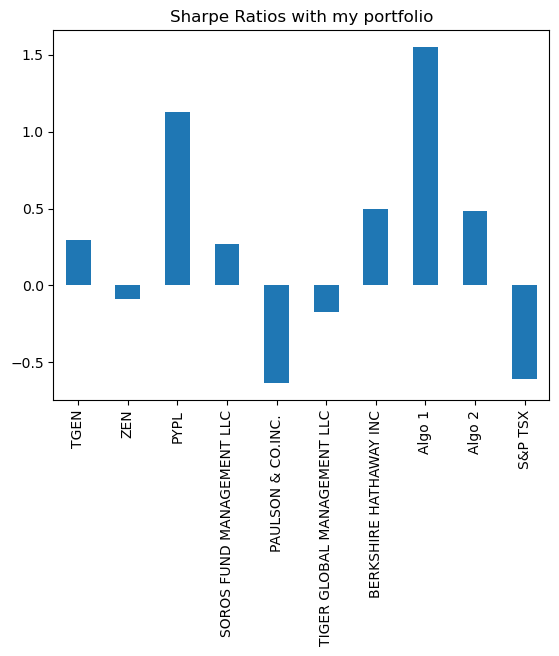

In [331]:
# Visualize the sharpe ratios as a bar plot
annualized_sharp_ratios.plot.bar(title='Sharpe Ratios with my portfolio')

### How does your portfolio do?

Write your answer here!
* My average Sharpe Ratio is less than that of the Algorithmic strategy, but better that the whale portfolios and S&P.